In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv(r'C:\Users\Banele\OneDrive\Desktop\customer churn\Churn_Modelling.csv')  # Update with your file path

In [5]:
# Check the first few rows of the dataset
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# Checking for missing values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
# Drop irrelevant columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [11]:
# Separate features and target variable
X = data.drop('Exited', axis=1)
y = data['Exited']

# Preprocessing for numerical and categorical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender']

In [13]:
# Preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

In [15]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [19]:
# Create a dictionary to store the results
results = {}

for name, model in models.items():
    # Create and train the pipeline
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Classification Report': report,
        'Model': clf
    }

In [20]:
# Print the results
print(f"Model: {name}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", report)



Model: Gradient Boosting
Accuracy: 0.8310
ROC AUC: 0.7966
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1607
           1       0.65      0.31      0.42       393

    accuracy                           0.83      2000
   macro avg       0.75      0.63      0.66      2000
weighted avg       0.81      0.83      0.81      2000



In [23]:
# Identify the best model based on ROC AUC
best_model_name = max(results, key=lambda x: results[x]['ROC AUC'])
best_model = results[best_model_name]['Model']
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', GradientBoostingClassifier())])

In [25]:
# Generate confusion matrix for the best model
y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)

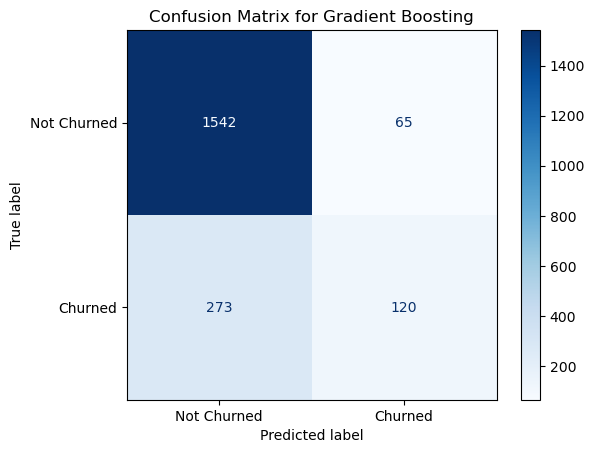

In [27]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

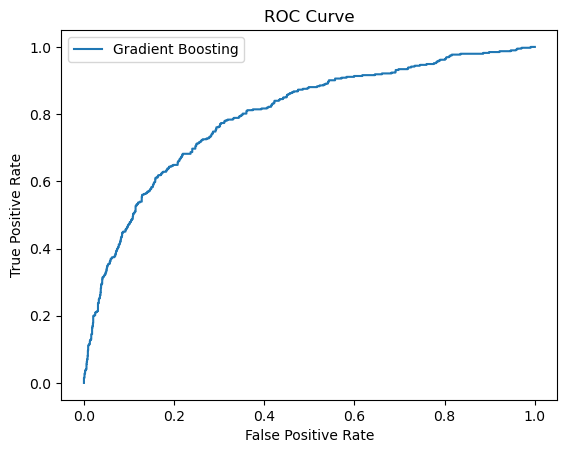

In [29]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=name)

# Show ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()